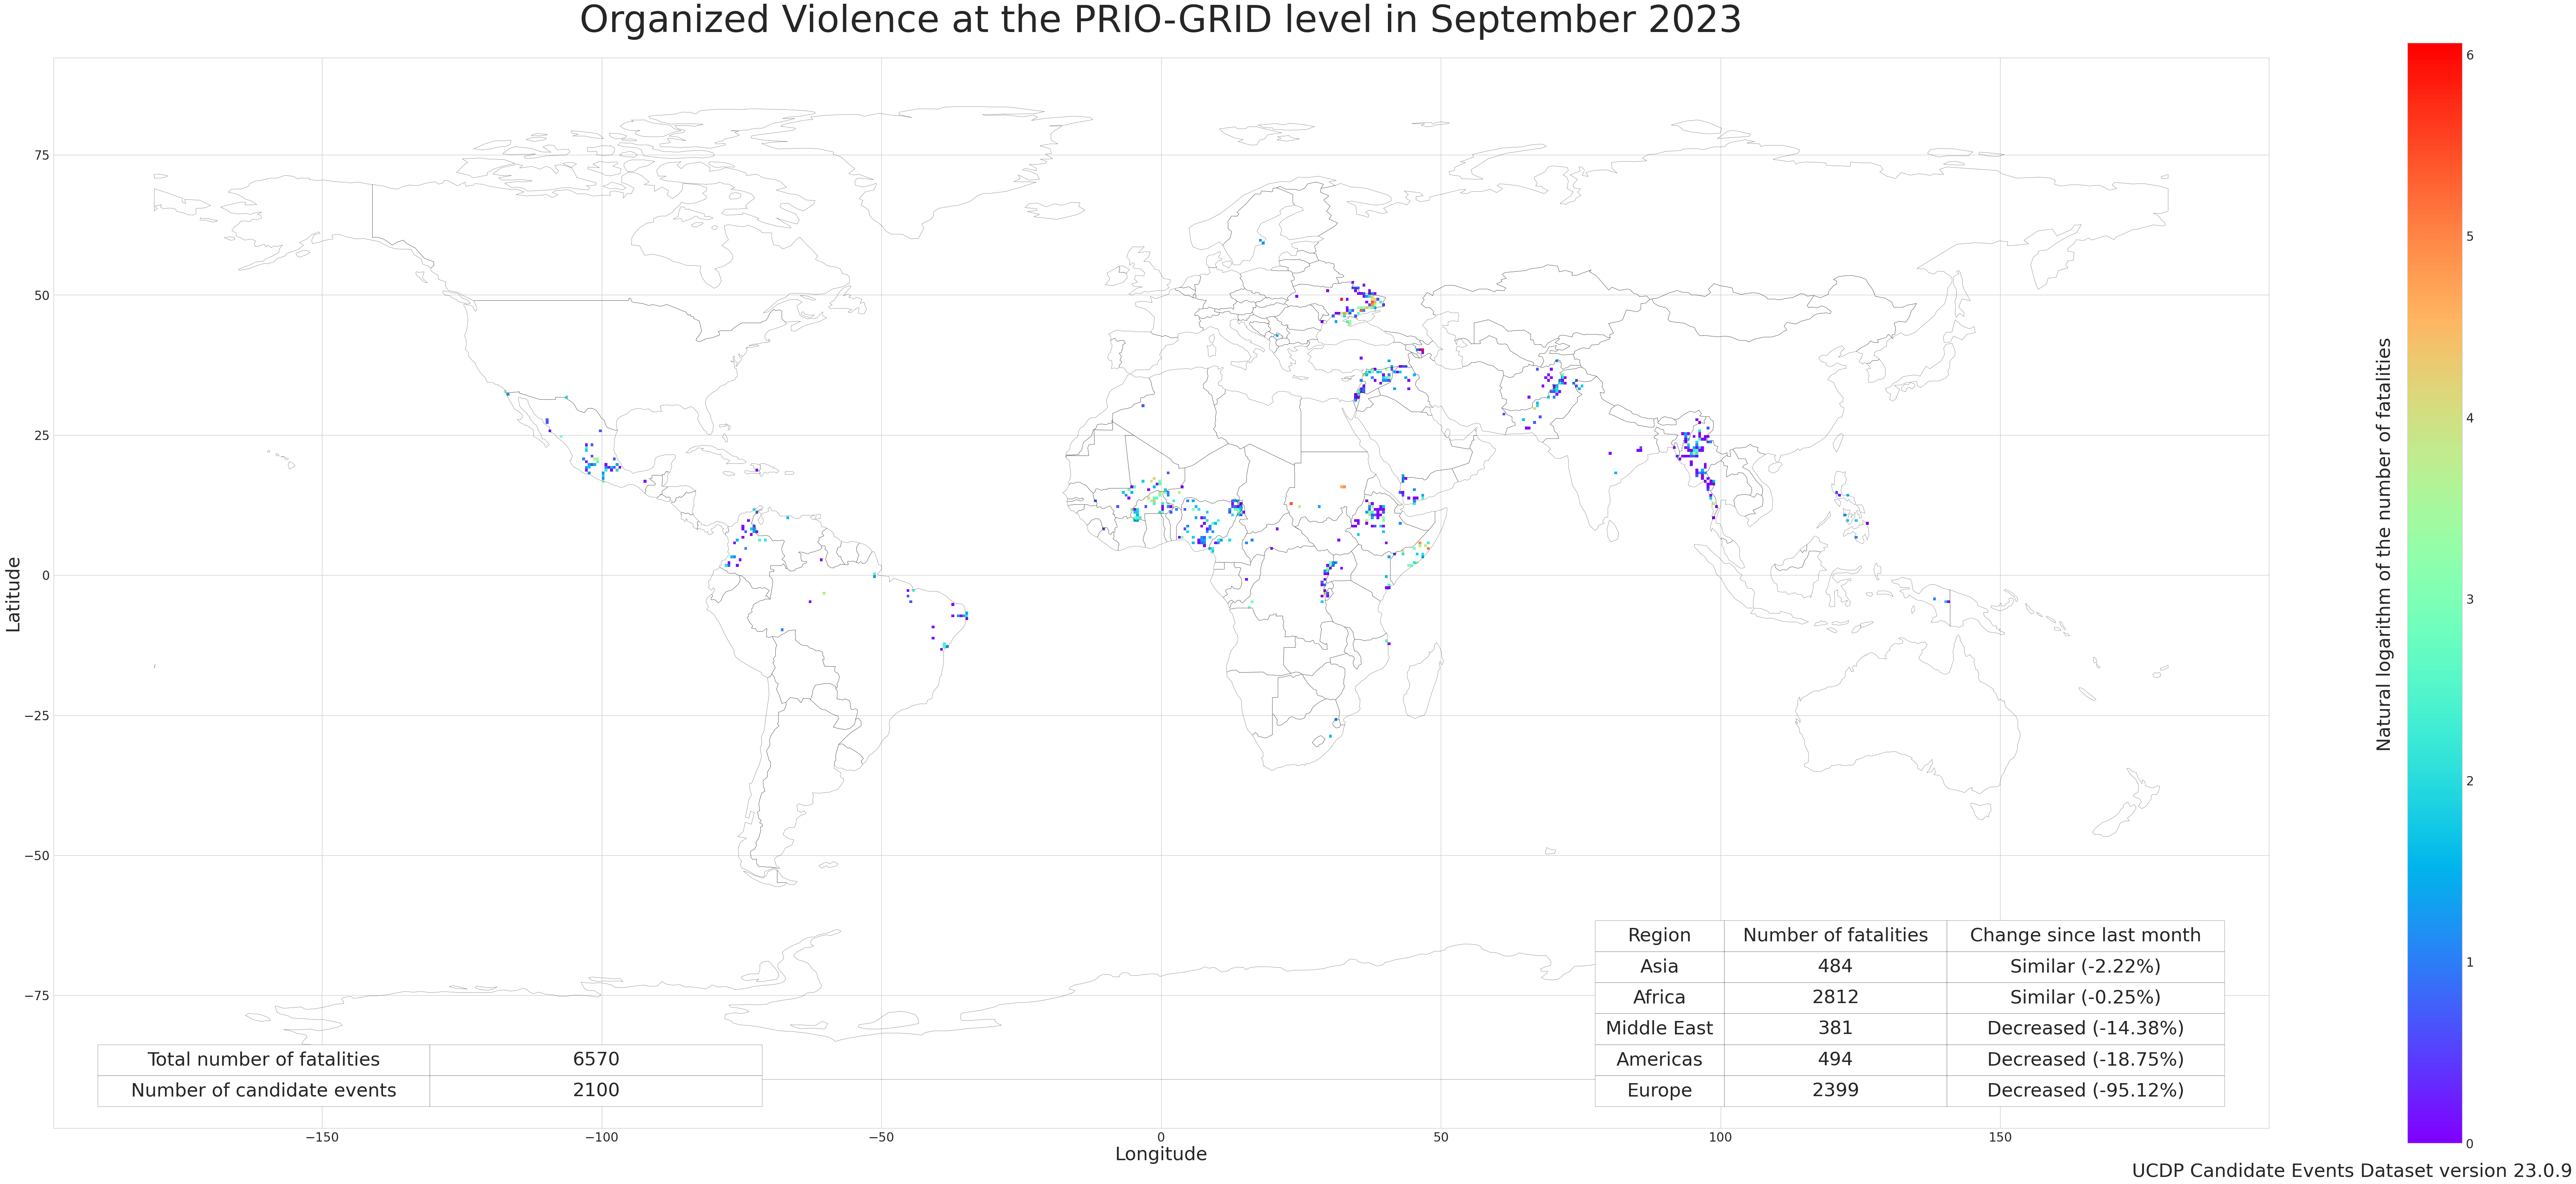

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import requests
from io import BytesIO
import shutil
import zipfile
import os

def input_ucdp_version():
    return input("Enter the UCDP Candidate Events Dataset version (e.g. 23.0.7): ")

def get_previous_month_version(version):
    year, _, month = version.split('.')
    year, month = int(year), int(month)
    if month == 1:
        month = 12
        year -= 1
    else:
        month -= 1
    return f"{year}.0.{month}"

def fetch_ucdp_data_for_version(api_url):
    page = 0
    data = []
    while True:
        response = requests.get(api_url + str(page))
        page_data = response.json()
        if not page_data['Result']:
            break
        data.extend(page_data['Result'])
        page += 1
    return pd.DataFrame(data)

def fetch_fatalities_by_region(df):
    return df.groupby('region')['best'].sum()

def format_percentage_change(region, curr_fatal, prev_fatal):
    if prev_fatal == 0:  
        if curr_fatal == 0:
            return region, curr_fatal, "Similar"
        else:
            return region, curr_fatal, "Increased"
    
    change = ((curr_fatal - prev_fatal) / prev_fatal) * 100

    if -5 < change < 5:  
        change_str = f"Similar ({change:.2f}%)"
    elif change > 5:  
        change_str = f"Increased ({change:.2f}%)"
    else:  
        change_str = f"Decreased ({change:.2f}%)"

    return region, curr_fatal, change_str

def extract_date_from_version(version):
    month_names = {
        1: "January", 2: "February", 3: "March", 4: "April", 5: "May", 
        6: "June", 7: "July", 8: "August", 9: "September", 10: "October", 
        11: "November", 12: "December"
    }

    year_str, _, month_str = version.split('.')
    year = int(year_str) + 2000  # converting '23' to 2023
    month = month_names[int(month_str)]
    return month, year

# Dowload PRIO-Grids and read shapefile
def get_prio_grids_shapefile(prio_grids_url):
    # Check if the .shp file already exists
    if not os.path.exists("priogrid_cell.shp"):
        print("Fetching PRIO-Grids shapefile from:", prio_grids_url)
        response = requests.get(prio_grids_url)
        with open("priogrid_cell.zip", "wb") as f:
            f.write(response.content)
        with zipfile.ZipFile("priogrid_cell.zip", "r") as zip_file:
            zip_file.extractall()
        os.remove("priogrid_cell.zip")

    # Read and return the shapefile
    prio_grids = gpd.read_file("priogrid_cell.shp")
    return prio_grids

version = input_ucdp_version()
month, year = extract_date_from_version(version)
month_year = f"{month} {year}"

previous_version = get_previous_month_version(version)
previous_month, previous_year = extract_date_from_version(previous_version)
previous_month_year = f"{previous_month} {previous_year}"

ucdp_api_url = f"https://ucdpapi.pcr.uu.se/api/gedevents/{version}?pagesize=1000&page="
ucdp_candidate = fetch_ucdp_data_for_version(ucdp_api_url)

previous_ucdp_api_url = f"https://ucdpapi.pcr.uu.se/api/gedevents/{previous_version}?pagesize=1000&page="
previous_ucdp_data = fetch_ucdp_data_for_version(previous_ucdp_api_url)

current_fatalities = fetch_fatalities_by_region(ucdp_candidate)
previous_fatalities = fetch_fatalities_by_region(previous_ucdp_data)

regions = ['Asia', 'Africa', 'Middle East', 'Americas', 'Europe']

fact_box_data = [
    [f"Total number of fatalities", f"{ucdp_candidate['best'].sum()}"],
    ["Number of candidate events", f"{len(ucdp_candidate)}"]
]

# Create a list to store the rows of the table
table_data = []
for region in regions:
    curr_fatal = current_fatalities.get(region, 0)
    prev_fatal = previous_fatalities.get(region, 0)
    region_name, curr_fatal, change_str = format_percentage_change(region, curr_fatal, prev_fatal)
    table_data.append([region_name, curr_fatal, change_str])

# Base map
world_map = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

# Fetch and merge PRIO-GRID data with UCDP Candidate data
prio_grids_url = "https://grid.prio.org/extensions/priogrid_cellshp.zip"
prio_grids = get_prio_grids_shapefile(prio_grids_url)
ucdp_cand_temp = ucdp_candidate.groupby(by=['priogrid_gid'])['best'].sum()
merged_data = prio_grids.merge(ucdp_cand_temp, left_on="gid", right_on="priogrid_gid")

with plt.style.context(("seaborn", "seaborn-whitegrid")):
    fig, ax1 = plt.subplots(figsize=(96, 64))

    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)

    merged_data["log_best"] = np.log(merged_data["best"].clip(lower=1))
    merged_data.plot(column="log_best",
                     ax=ax1,
                     legend=True,
                     legend_kwds={'shrink': 0.60},
                     cmap=plt.cm.rainbow).figure.axes[1].tick_params(labelsize=24)
    ax1.set_title(f'Organized Violence at the PRIO-GRID level in {month_year}', pad=50, size=72)
    ax1.set_ylabel('Latitude', fontsize=36)
    ax1.set_xlabel('Longitude', fontsize=36)

    world_map.plot(facecolor="none",
                   ax=ax1,
                   edgecolor="black")

    # Adding the fact box as a table to the plot
    fact_box_table = ax1.table(cellText=fact_box_data, fontsize=36, loc='lower left', cellLoc='center', zorder=6)
    fact_box_table.auto_set_font_size(False)
    fact_box_table.set_fontsize(36)
    fact_box_table.scale(0.3, 5)  # You can adjust the table size using the scale function

    # Adding the table to the plot
    table_columns = ['Region', 'Number of fatalities', 'Change since last month']
    table = ax1.table(cellText=table_data, colLabels=table_columns, fontsize=36, loc='lower right', cellLoc='center', zorder=6)
    table.auto_set_font_size(False)
    table.set_fontsize(36)
    table.scale(0.3, 5)  # You can adjust the table size using the scale function
    table.auto_set_column_width(col=list(range(len(table_columns)))) # Adjust column width

    # Additionally, you can set the background of the table area
    plt.figtext(0.78, 0.43, "Natural logarithm of the number of fatalities", rotation='vertical', ha="right", fontsize=36)
    plt.figtext(0.83, 0.25, f"UCDP Candidate Events Dataset version {version}", ha="right", fontsize=36)
    plt.rcParams['font.family'] = 'Open Sans'

    fig.savefig(f'GEDEvent_v{version.replace(".", "_")}.pdf', bbox_inches='tight', pad_inches=5)